In [2]:
import scanpy as sc
import squidpy as sq
import matplotlib.pyplot as plt
import os

C:\Users\Roulis_Lab\AppData\Roaming\Python\Python312\site-packages\dask\dataframe\__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
C:\Users\Roulis_Lab\AppData\Roaming\Python\Python312\site-packages\xarray_schema\__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
C:\Users\Roulis_Lab\AppData\Roaming\Python\Python312\site-packages\anndata\utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWar

In [ ]:
adata_sp = sc.read_h5ad('adata.h5ad')
print(adata_sp)

C:\Users\Roulis_Lab\AppData\Roaming\Python\Python312\site-packages\anndata\_core\aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 1348582 × 990
    obs: 'x', 'y', 'Mouse_ID', 'Technical_repeat_number', 'Sample_type', 'Slice_ID', 'FOV', 'Cell_ID', 'sample', 'N_genes', 'Tier1', 'Tier2', 'Tier3', 'Leiden_neigh', 'Neigh_umap_x', 'Neigh_umap_y', 'Tier2_umap_x', 'Tier2_umap_y', 'Tier3_umap_x', 'Tier3_umap_y', 'Tier1_umap_x', 'Tier1_umap_y'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Neigh_anndata', 'Sample_type_colors', 'Tier1_colors', 'Tier2_colors', 'Tier3_colors', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


In [4]:
adata = sc.read_h5ad('combined_mouse_colon.h5ad')
print(adata)

AnnData object with n_obs × n_vars = 7181 × 16693
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.5', 'seurat_clusters', 'doublet_class', 'Epithelial_sum_expr', 'PanImmune_sum_expr', 'PlasmaCell_sum_expr', 'NKCell_sum_expr', 'Myeloid_sum_expr', 'Monocyte_Mac_sum_expr', 'Dendritic_sum_expr', 'MastCell_sum_expr', 'Endothelial_sum_expr', 'Lymphatic_Endo_sum_expr', 'Glial_sum_expr', 'Pericyte_sum_expr', 'SMC_sum_expr', 'Fibroblast_sum_expr', 'cell_type', 'condition', 'mouse', 'Epithelial_marker_sum', 'PanImmune_marker_sum', 'PlasmaCell_marker_sum', 'NKCell_marker_sum', 'Myeloid_marker_sum', 'Monocyte_Mac_marker_sum', 'Dendritic_marker_sum', 'MastCell_marker_sum', 'Endothelial_marker_sum', 'Lymphatic_Endo_marker_sum', 'Glial_marker_sum', 'Pericyte_marker_sum', 'SMC_marker_sum', 'Fibroblast_marker_sum', 'predicted.id', 'prediction.score.SMC', 'prediction.score.Lymphatic.endothelial', 'prediction.score.Fibroblasts', 'prediction.score.Vascular.endothelial', 'p

In [11]:
# Create a spatial embedding in the reference AnnData
coords_ref = adata_sp.obs[['x','y']].to_numpy()
adata_sp.uns['spatial'] = coords_ref      

print(adata_sp.obsm['spatial'].shape)

(1348582, 2)


In [ ]:
x = adata_sp.obs['x']
y = adata_sp.obs['y']
labels = adata_sp.obs['Tier1']

tier1_colors = adata_sp.uns['Tier1_colors']
if isinstance(tier1_colors, dict):
    color_dict = tier1_colors
else:
    unique_labels = adata_sp.obs['Tier1'].cat.categories
    color_dict = dict(zip(unique_labels, tier1_colors))


In [50]:
slices = adata_sp.obs["Slice_ID"].unique()
# Select a specific slice for analysis
slice_D9 = [slice for slice in slices if "D9" in slice]
print(slice_D9)
slice_id = "062921_D0_m3a_1_slice_1"
ad_slice = adata_sp[adata_sp.obs['Slice_ID'] == slice_id].copy()

['062221_D9_m3_2_slice_3', '062221_D9_m3_2_slice_2', '062221_D9_m3_2_slice_1', '100221_D9_m3_1_slice_2', '100221_D9_m3_1_slice_1', '100221_D9_m3_2_slice_1', '100221_D9_m3_2_slice_2', '100221_D9_m2_1_slice_1', '100221_D9_m2_1_slice_2', '100221_D9_m2_1_slice_3', '062921_D9_m2a_1_slice_1', '062921_D9_m2a_2_slice_2', '062921_D9_m2a_2_slice_1', '062921_D9_m5_1_slice_3', '062921_D9_m5_1_slice_2', '062921_D9_m5_1_slice_1', '100221_D9_m5_1_slice_1', '100221_D9_m5_1_slice_2', '100221_D9_m5_1_slice_3', '100221_D9_m5_2_slice_1', '100221_D9_m5_2_slice_2', '100221_D9_m5_2_slice_3', '062921_D9_m5_2_slice_1', '062921_D9_m5_2_slice_2', '062921_D9_m5_2_slice_3']


C:\Users\Roulis_Lab\AppData\Local\Temp\ipykernel_14868\2211003820.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1200x1200 with 0 Axes>

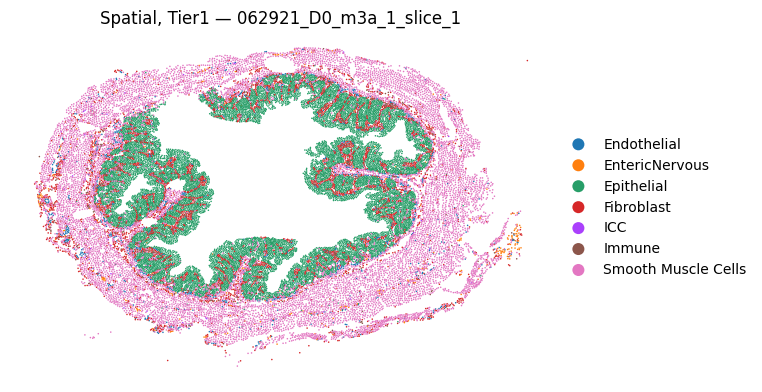

In [51]:
plt.figure(figsize=(6,6), dpi=200)
ax = sc.pl.scatter(
    ad_slice,
    x='x', y='y',
    color='Tier1',
    palette=adata_sp.uns['Tier1_colors'],
    size=5,         # tweak dot size as needed
    alpha=1.0,
    legend_loc='right margin',
    show=False      # so we can invert y before display
)

ax.invert_yaxis()

plt.title(f"Spatial, Tier1 — {slice_id}")
plt.axis('off')
plt.tight_layout()
plt.show()

In [64]:
shared = adata.var_names.intersection(adata_sp.var_names)
adata_ref  = adata[:,  shared].copy()
adata_query = adata_sp[:, shared].copy()

In [75]:
adata_ref.obsm['X_pca']  = adata_ref.obsm['PCA']
adata_ref.obsm['X_umap'] = adata_ref.obsm['UMAP']
adata_ref.uns['umap'] = adata_ref.obsm['X_umap']

In [77]:
sc.pp.neighbors(adata_ref, n_neighbors=15, use_rep='X_pca')
sc.tl.umap(adata_ref)
sc.tl.ingest(adata_query, adata_ref, obs='cell_type')
adata_sp.obs['predicted_cell_type'] = adata_query.obs['cell_type']

C:\Users\Roulis_Lab\AppData\Roaming\Python\Python312\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


AttributeError: 'Ingest' object has no attribute '_pca_use_hvg'

In [ ]:
slices = adata_sp.obs["Slice_ID"].unique()
# Select a specific slice for analysis
slice_D9 = [slice for slice in slices if "D9" in slice]
print(slice_D9)
slice_id = "062921_D0_m3a_1_slice_1"
ad_slice = adata_query[adata_query.obs['Slice_ID'] == slice_id].copy()

In [ ]:
plt.figure(figsize=(6,6), dpi=200)
ax = sc.pl.scatter(
    ad_slice,
    x='x', y='y',
    color='Tier1',
    palette=adata_query.obs['cell_type'].cat.categories,
    size=5,         # tweak dot size as needed
    alpha=1.0,
    legend_loc='right margin',
    show=False      # so we can invert y before display
)

ax.invert_yaxis()

plt.title(f"Spatial, Tier1 — {slice_id}")
plt.axis('off')
plt.tight_layout()
plt.show()

In [32]:
# Define your cell-type markers
celltype_markers = {
  "Epithelial":       ["Cdh1","Epcam","Alpi","Muc2","Vil1","Lyz1","Lgr5","Olfm4","Ccnd1"],
  "PanImmune":        ["Ptprc"],
  "BCell":            ["Ms4a1","Cd19"],
  "PlasmaCell":       ["Mzb1","Ccr10","Sdc1"],
  "TCell":            ["Cd3e"],
  "CD4_TCell":        ["Cd4"],
  "CD8_TCell":        ["Cd8a","Cd8b"],
  "NKCell":           ["Nkg7","Ncam1"],
  "Myeloid":          ["Cd68","Cd74"],
  "Monocyte_Mac":     ["Cd14"],
  "Dendritic":        ["Itgax"],
  "MastCell":         ["Kit","Il1rl1"],
  "Treg":             ["Foxp3"],
  "Endothelial":      ["Pecam1"],
  "Lymphatic_Endo":   ["Lyve1"],
  "Glial":            ["Plp1","S100b"],
  "Pericyte":         ["Rgs5","Pdgfrb","Adipoq"],
  "SMC":              ["Myh11","Actg2","Myocd","Des","Acta2"],
  "Fibroblast":       ["Pdgfra","Sparc","Dcn","Lum","Col1a1","Col14a1","Fgfr2",
                       "Col3a1","Col4a5","Col4a6","Bmp5","Bmp4","Grem1","Vcam1",
                       "Ogn","Mgp","Sfrp2","C3","Dpt"]
}


In [37]:
out_dir = "SpatialPlots"
os.makedirs(out_dir, exist_ok=True)

# loop markers, plot HC vs DSS side by side
for celltype, markers in celltype_markers.items():
    for gene in markers:
        if gene not in adata.var_names:
            continue
        fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
        # HC
        sc.pl.spatial(
            adata[adata.obs["condition"] == "HC"],
            color       = gene,
            ax          = axes[0],
            title       = f"HC — {gene}",
            spot_size   = 30,
            show        = False
        )
        # DSS
        sc.pl.spatial(
            adata[adata.obs["condition"] == "DSS"],
            color       = gene,
            ax          = axes[1],
            title       = f"DSS — {gene}",
            spot_size   = 30,
            show        = False
        )
        fig.tight_layout()
        # save into SpatialPlots/
        save_path = os.path.join(out_dir, f"Spatial_{celltype}_{gene}.png")
        fig.savefig(save_path, dpi=300)
        plt.close(fig)


C:\Users\Roulis_Lab\AppData\Local\Temp\ipykernel_22164\1493527844.py:11: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(
C:\Users\Roulis_Lab\AppData\Local\Temp\ipykernel_22164\1493527844.py:20: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


In [38]:
adata_sp.write('adata_copy.h5ad')
adata.write('combined_copy.h5ad')